In [1]:
%load_ext autoreload
%autoreload 2

import jax  # noqa: I001
jax.config.update("jax_enable_x64", True)

import numpyro  # noqa: E402, I001
numpyro.set_host_device_count(4)

import numpy as np  # noqa: E402, I001

import ultraplot as uplt  # noqa: E402, I001
import h5py  # noqa: E402, I001

In [2]:
corr_nz = {}
corr_mz = {}
corr_dz = {}

with h5py.File("des_y6_nz_SOMPZ_WZ_imsim_v2_num_bins9_w0p1.h5", "r") as fp:
    for k in fp.keys():
        corr_nz[k] = fp[k]["nz"][()]
        corr_mz[k] = fp[k]["m"][()]
        corr_dz[k] = fp[k]["dz"][()]

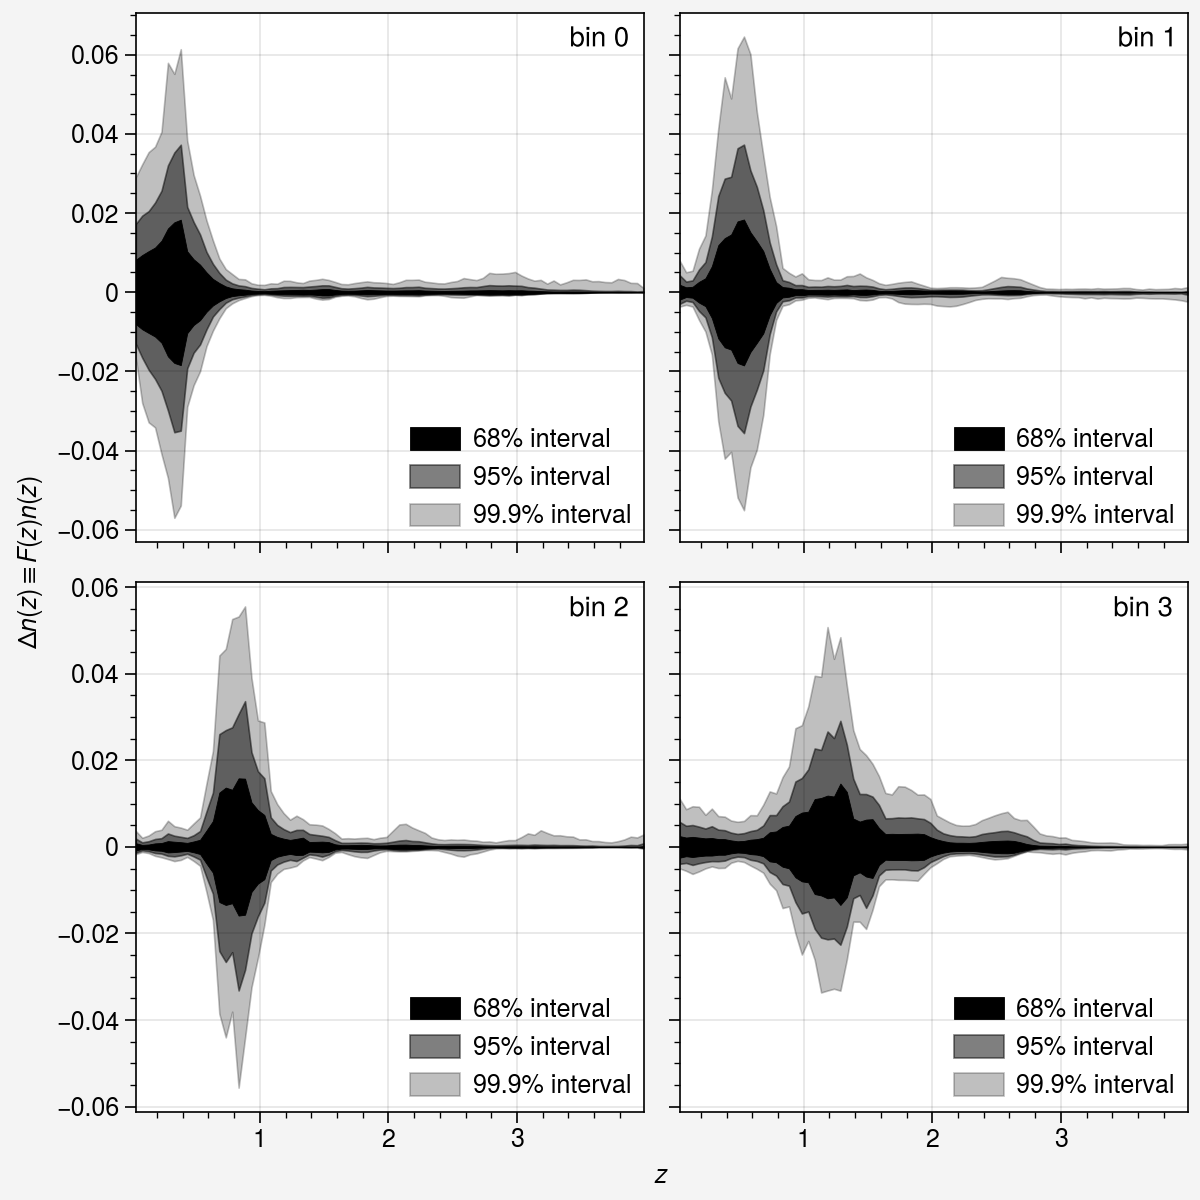

In [3]:
from des_y6_imsim_analysis.utils import GMODEL_COSMOS_Z

fig, axs = uplt.subplots(
    nrows=2,
    ncols=2,
    figsize=(6, 6),
)

rng = np.random.default_rng(42)
n_sample = 100

bind = 0
for i in range(2):
    for j in range(2):
        ax = axs[i, j]

        # rinds = rng.choice(corr_nz[key].shape[0], replace=False, size=n_sample)
        # for pi in range(n_sample):
        #     ax.plot(
        #         GMODEL_COSMOS_Z[1:-1],
        #         corr_nz[key][rinds[pi], bind] - np.mean(corr_nz[key][:, bind, :], axis=0),
        #         color="k",
        #         alpha=0.2,
        #     )
        dnz = []
        for key in corr_nz.keys():
            dnz.append(
                corr_nz[key][:, bind, :] - np.mean(corr_nz[key][:, bind, :], axis=0, keepdims=True)
            )
        dnz = np.concatenate(dnz, axis=0)

        for pval, alpha in zip([68, 95, 99.9], [1.0, 0.5, 0.25]):
            uval = 100 - (100 - pval) / 2
            dval = (100 - pval) / 2

            dnz_up = np.percentile(dnz[:, :], uval, axis=0)
            dnz_down = np.percentile(dnz[:, :], dval, axis=0)
            ax.fill_between(
                GMODEL_COSMOS_Z[1:-1],
                dnz_down,
                dnz_up,
                color="k",
                alpha=alpha,
                label=f"{pval}% interval",
            )

        # for pi in range(n_sample):
        #     ax.plot(
        #         GMODEL_COSMOS_Z[1:-1],
        #         corr_nz[key][rinds[pi], bind] - np.mean(corr_nz[key][:, bind, :], axis=0),
        #         color="k",
        #         alpha=0.2,
        #     )
        ax.format(
            xlabel=r"$z$",
            ylabel=r"$\Delta n(z) \equiv F(z) n(z)$",
            abc=[f"${{\\rm  bin}}\\ {_bind}$" for _bind in range(4)],
            abcloc="ur",
        )
        ax.legend(
            loc="lr",
            frameon=False,
            ncols=1
        )

        bind += 1

In [4]:
mvals = []
dzvals = []
for key in corr_mz.keys():
    mvals.append(corr_mz[key])
    dzvals.append(corr_dz[key])
mvals = np.concatenate(mvals, axis=0)
dzvals = np.concatenate(dzvals, axis=0)

In [ ]:
from des_y6_imsim_analysis.utils import sompz_integral, compute_nz_binned_mean, shift_negative_nz_values

nn_data_to_save = {}

mvals_nn = []
dzvals_nn = []

for key in corr_mz.keys():
    nn_data_to_save[key] = {}
    orig_z = np.array([
        [
            compute_nz_binned_mean(corr_nz[key][si, bi, :])
            for bi in range(4)
        ]
        for si in range(corr_nz[key].shape[0])
    ])
    curr_nrm_orig = np.array([
        [float(sompz_integral(corr_nz[key][si, bi, :], 0, 6)) for bi in range(4)]
        for si in range(corr_nz[key].shape[0])
    ])
    curr_nrm_orig = curr_nrm_orig[:, :, np.newaxis]
    orig_nz = corr_nz[key] / curr_nrm_orig * (1.0 + corr_mz[key][:, :, np.newaxis])
    new_mvals = np.array([
        [
            float(sompz_integral(orig_nz[si, bi, :], 0, 6) - 1)
            for bi in range(4)
        ]
        for si in range(orig_nz.shape[0])
    ])
    print(f"max abs diff `m` after renorm for key={key}:", np.max(np.abs(new_mvals - corr_mz[key])))

    for ri in range(orig_nz.shape[0]):
        for bi in range(orig_nz.shape[1]):
            orig_nz[ri, bi, :] = shift_negative_nz_values(orig_nz[ri, bi, :])

    nn_data_to_save[key]["m"] = np.array(
        [
            [float(sompz_integral(orig_nz[si, bi, :], 0, 6) - 1) for bi in range(4)]
            for si in range(orig_nz.shape[0])
        ]
    )

    mvals_nn.append(nn_data_to_save[key]["m"].copy())

    orig_nz = orig_nz / np.sum(orig_nz, axis=-1, keepdims=True)

    nn_data_to_save[key]["nz"] = orig_nz.copy()

    nn_data_to_save[key]["dz"] = np.array([
            [
                float(
                    compute_nz_binned_mean(orig_nz[si, bi, :])
                    # this term is
                    #   - (<z>_eff - (<z>_eff - <z>_sompzwz))
                    #   - (<z>_sompzwz)
                    - (orig_z[si, bi] - corr_dz[key][si, bi])
                )
                for bi in range(4)
            ]
            for si in range(orig_nz.shape[0])
    ])
    dzvals_nn.append(nn_data_to_save[key]["dz"].copy())

mvals_nn = np.concatenate(mvals_nn, axis=0)
dzvals_nn = np.concatenate(dzvals_nn, axis=0)

print(mvals_nn.shape, dzvals_nn.shape)

max abs diff `m` after renorm for key=statistical: 8.881784197001252e-16
max abs diff `m` after renorm for key=statistical-neighbor: 8.881784197001252e-16
max abs diff `m` after renorm for key=statistical-neighbor-occupancy: 1.1102230246251565e-15
max abs diff `m` after renorm for key=statistical-occupancy: 1.1102230246251565e-15
(40380, 4) (40380, 4)


In [6]:
with h5py.File("des_y6_nz_SOMPZ_WZ_imsim_v2.1_num_bins9_w0p1_nonneg.h5", "w") as fp:
    for key in nn_data_to_save.keys():
        fp.create_dataset(f"{key}/m", data=nn_data_to_save[key]["m"])
        fp.create_dataset(f"{key}/dz", data=nn_data_to_save[key]["dz"])
        fp.create_dataset(f"{key}/nz", data=nn_data_to_save[key]["nz"])

In [10]:
m_mn = np.mean(mvals, axis=0)
m_sd = np.std(mvals, axis=0)

dz_mn = np.mean(dzvals, axis=0)
dz_sd = np.std(dzvals, axis=0)

print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] |dz [1sigma]       |")
print("|--------------------------------------------|")
for i in range(4):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] |dz [1sigma]       |
|--------------------------------------------|
| 0   |  -3.4 +/- 22.0    | -0.018 +/- 0.008 |
| 1   |  +0.7 +/- 27.8    | -0.037 +/- 0.012 |
| 2   | +19.8 +/- 21.9    | -0.005 +/- 0.007 |
| 3   |  -8.1 +/- 39.3    | -0.044 +/- 0.012 |
|--------------------------------------------|


In [11]:
m_mn = np.mean(mvals_nn, axis=0)
m_sd = np.std(mvals_nn, axis=0)

dz_mn = np.mean(dzvals_nn, axis=0)
dz_sd = np.std(dzvals_nn, axis=0)

print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz [1sigma]      |")
print("|--------------------------------------------|")
for i in range(4):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz [1sigma]      |
|--------------------------------------------|
| 0   |  -3.4 +/- 22.0    | -0.018 +/- 0.008 |
| 1   |  +0.7 +/- 27.8    | -0.037 +/- 0.012 |
| 2   | +19.8 +/- 21.9    | -0.005 +/- 0.007 |
| 3   |  -8.1 +/- 39.3    | -0.044 +/- 0.012 |
|--------------------------------------------|
